## Import libraries

In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import re

# Data prepare
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# ML models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Gradient Boosting
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ML metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

## Downloading datasets

In [3]:
PATH = '/kaggle/input/titanic'

In [4]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))

In [5]:
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [6]:
target = pd.read_csv(os.path.join(PATH, 'gender_submission.csv'))

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
target.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
All data is successfully downloaded.
   
</div>

## Data prepare

### train

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
train.duplicated().sum()

0

In [12]:
for i in train.columns:
    if i!='Name' and i!='Ticket' and i!='PassengerId':
        print(i)
        print(train[i].unique())
        print('')

Survived
[0 1]

Pclass
[3 1 2]

Sex
['male' 'female']

Age
[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]

SibSp
[1 0 3 4 2 5 8]

Parch
[0 1 2 5 3 4 6]

Fare
[  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.687

In [13]:
train['Age'] = train['Age'].fillna(train['Age'].median())

In [14]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [15]:
train['Cabin'] = train['Cabin'].str.extract(r'([A-Z]+)')

In [16]:
train['Cabin'] = train['Cabin'].fillna('Unknown')

In [17]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### New features

In [18]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

In [19]:
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)

In [20]:
train['AgeGradation'] = pd.cut(train['Age'],
                                bins=[0, 7, 14, 21, 50, 100],
                                labels=['baby', 'child', 'teenager', 'adult', 'old'])

In [21]:
train['FareGradation'] = pd.qcut(train['Fare'],
                                 q=5,
                                 labels=['very low', 'low', 'medium', 'high', 'very high'])

In [22]:
train = (train
         .drop(['Ticket', 'Name'], axis=1)
         .dropna())

In [23]:
train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,IsAlone,AgeGradation,FareGradation
187,188,1,1,male,45.0,0,0,26.550,Unknown,S,1,1,adult,high
435,436,1,1,female,14.0,1,2,120.000,B,S,4,0,child,very high
564,565,0,3,female,28.0,0,0,8.050,Unknown,S,1,1,adult,low
292,293,0,2,male,36.0,0,0,12.875,D,C,1,1,adult,medium
783,784,0,3,male,28.0,1,2,23.450,Unknown,S,4,0,adult,high


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Age feature filled. NaN's droped.
   
</div>

### Test

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [25]:
test.duplicated().sum()

0

In [26]:
for i in test.columns:
    if i!='Name' and i!='Ticket' and i!='PassengerId':
        print(i)
        print(test[i].unique())
        print('')

Pclass
[3 2 1]

Sex
['male' 'female']

Age
[34.5  47.   62.   27.   22.   14.   30.   26.   18.   21.     nan 46.
 23.   63.   24.   35.   45.   55.    9.   48.   50.   22.5  41.   33.
 18.5  25.   39.   60.   36.   20.   28.   10.   17.   32.   13.   31.
 29.   28.5  32.5   6.   67.   49.    2.   76.   43.   16.    1.   12.
 42.   53.   26.5  40.   61.   60.5   7.   15.   54.   64.   37.   34.
 11.5   8.    0.33 38.   57.   40.5   0.92 19.   36.5   0.75  0.83 58.
  0.17 59.   14.5  44.    5.   51.    3.   38.5 ]

SibSp
[0 1 2 3 4 5 8]

Parch
[0 1 3 2 4 6 5 9]

Fare
[  7.8292   7.       9.6875   8.6625  12.2875   9.225    7.6292  29.
   7.2292  24.15     7.8958  26.      82.2667  61.175   27.7208  12.35
   7.225    7.925   59.4      3.1708  31.6833  61.3792 262.375   14.5
  61.9792  30.5     21.6792  31.5     20.575   23.45    57.75     8.05
   9.5     56.4958  13.4167  26.55     7.85    13.      52.5542  29.7
   7.75    76.2917  15.9     60.      15.0333  23.     263.      15.5792
  2

In [27]:
test['Age'] = test['Age'].fillna(test['Age'].median())

In [28]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [29]:
test['Cabin'] = test['Cabin'].str.extract(r'([A-Z]+)')

In [30]:
test['Cabin'] = test['Cabin'].fillna('Unknown')

In [31]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### New features

In [32]:
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [33]:
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

In [34]:
test['AgeGradation'] = pd.cut(test['Age'],
                              bins=[0, 7, 14, 21, 50, 100],
                              labels=['baby', 'child', 'teenager', 'adult', 'old'])

In [35]:
test['FareGradation'] = pd.qcut(test['Fare'],
                                q=5,
                                labels=['very low', 'low', 'medium', 'high', 'very high'])

In [36]:
test = (test
         .drop(['Ticket', 'Name'], axis=1)
         .dropna())

In [37]:
test.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,IsAlone,AgeGradation,FareGradation
144,1036,1,male,42.0,0,0,26.5500,Unknown,S,1,1,adult,high
294,1186,3,male,36.0,0,0,9.5000,Unknown,S,1,1,adult,low
248,1140,2,female,29.0,1,0,26.0000,Unknown,S,2,0,adult,high
401,1293,2,male,38.0,1,0,21.0000,Unknown,S,2,0,adult,medium
216,1108,3,female,27.0,0,0,7.8792,Unknown,Q,1,1,adult,low


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Age feature filled. NaN's droped.
   
</div>

### Gender_submission

In [38]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Data is OK.
   
</div>

## EDA

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Cabin          891 non-null    object  
 9   Embarked       891 non-null    object  
 10  FamilySize     891 non-null    int64   
 11  IsAlone        891 non-null    int64   
 12  AgeGradation   891 non-null    category
 13  FareGradation  891 non-null    category
dtypes: category(2), float64(2), int64(7), object(3)
memory usage: 85.8+ KB


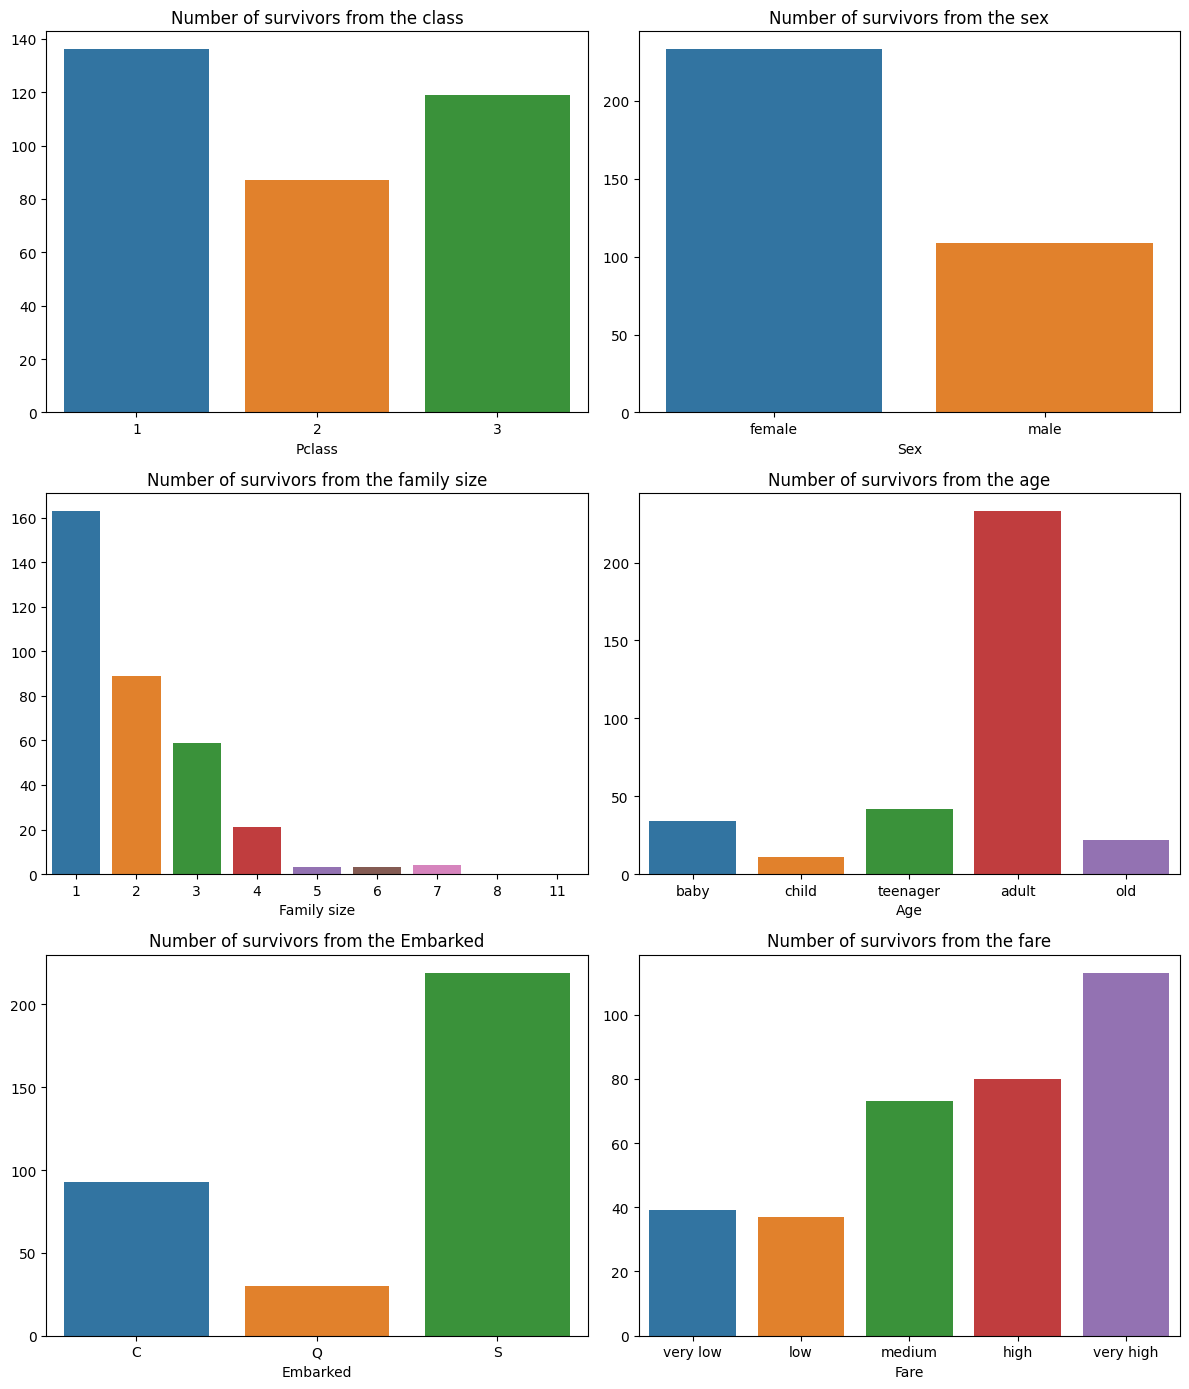

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(12, 14))

data = train.pivot_table(columns='Pclass', values='Survived', aggfunc='sum')

ax[0,0] = sns.barplot(data, ax=ax[0,0])
ax[0,0].set_title('Number of survivors from the class', fontsize=12)
ax[0,0].set_xlabel('Pclass', fontsize=10)
ax[0,0].set_ylabel('', fontsize=10)

data = train.pivot_table(columns='Sex', values='Survived', aggfunc='sum')

ax[0,1] = sns.barplot(data, ax=ax[0,1])
ax[0,1].set_title('Number of survivors from the sex', fontsize=12)
ax[0,1].set_xlabel('Sex', fontsize=10)
ax[0,1].set_ylabel('', fontsize=10)

data = train.pivot_table(columns='FamilySize', values='Survived', aggfunc='sum')

ax[1,0] = sns.barplot(data, ax=ax[1,0])
ax[1,0].set_title('Number of survivors from the family size', fontsize=12)
ax[1,0].set_xlabel('Family size', fontsize=10)
ax[1,0].set_ylabel('', fontsize=10)

data = train.pivot_table(columns='AgeGradation', values='Survived', aggfunc='sum', observed=True)

ax[1,1] = sns.barplot(data, ax=ax[1,1])
ax[1,1].set_title('Number of survivors from the age', fontsize=12)
ax[1,1].set_xlabel('Age', fontsize=10)
ax[1,1].set_ylabel('', fontsize=10)

data = train.pivot_table(columns='Embarked', values='Survived', aggfunc='sum')

ax[2,0] = sns.barplot(data, ax=ax[2,0])
ax[2,0].set_title('Number of survivors from the Embarked', fontsize=12)
ax[2,0].set_xlabel('Embarked', fontsize=10)
ax[2,0].set_ylabel('', fontsize=10)

data = train.pivot_table(columns='FareGradation', values='Survived', aggfunc='sum', observed=True)

ax[2,1] = sns.barplot(data, ax=ax[2,1])
ax[2,1].set_title('Number of survivors from the fare', fontsize=12)
ax[2,1].set_xlabel('Fare', fontsize=10)
ax[2,1].set_ylabel('', fontsize=10)

plt.tight_layout()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
Typical survivor is an adult female from Southampton without family.
   
</div>

## Correlation matrix

In [41]:
num_cols = ['FamilySize', 'Age', 'SibSp', 'Parch', 'Fare']

In [42]:
cat_cols = ['Pclass', 'Sex', 'Embarked', 'Cabin', 'IsAlone', 'AgeGradation', 'FareGradation']

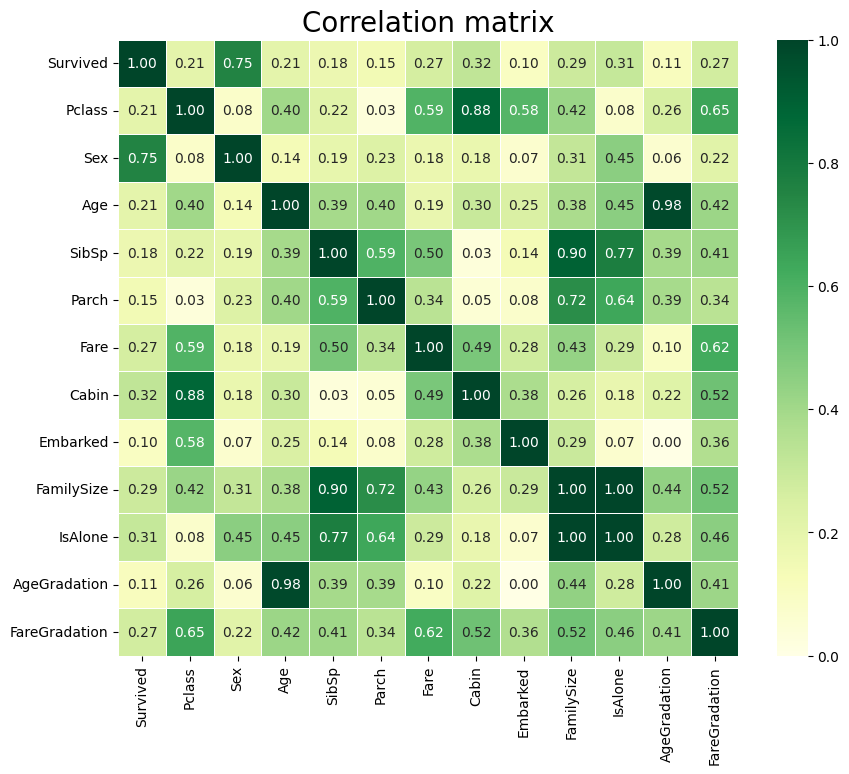

In [43]:
plt.figure(figsize=(10, 8))

sns.heatmap(phik.phik_matrix(train.drop('PassengerId', axis=1), interval_cols=num_cols),
            annot=True, cmap='YlGn', vmin=0, vmax=1, linewidth=.5, fmt='.2f', square=False)
plt.title('Correlation matrix', fontsize=20)
plt.show()

## ML prepare

In [44]:
X_train = train.drop(['PassengerId', 'Survived'], axis=1)

In [45]:
X_test = test.drop(['PassengerId'], axis=1)

In [46]:
y_train = train['Survived']

In [47]:
y_test = target.drop(['PassengerId'], axis=1)

In [48]:
cat_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [49]:
num_pipe = Pipeline(steps = [
    ('num', StandardScaler())
])

In [50]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='passthrough')

In [51]:
pipe = Pipeline(steps = [
    ('data_prepare', preprocessor),
    ('model', LogisticRegression(random_state=42))
])

## ML

### Random search

In [52]:
hyperparam = [
    
    {'model': [RandomForestClassifier(random_state=42)],
     'model__n_estimators': [50, 100, 200, 400, 500, 800],
     'model__max_depth': [None, 5, 10, 15, 20, 25, 30, 40, 50],
     'model__min_samples_split': [2, 5, 10, 15, 20, 30, 50],
     'model__min_samples_leaf': [1, 2, 4, 8, 10, 15],
     'model__max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.9],
     'model__criterion': ['gini', 'entropy'],
     'model__bootstrap': [False],
     'model__max_samples': [None, 0.7, 0.8, 0.9],
     'model__class_weight': [None, 'balanced', 'balanced_subsample'],
     'model__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
     'model__ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0]},
    
    {'model': [SVC(random_state=42)],
     'model__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100, 1000],
     'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 0.5, 1, 2, 5],
     'model__degree': [2, 3, 4, 5, 6],
     'model__coef0': [0.0, 0.1, 0.5, 1.0, 2.0],
     'model__shrinking': [True, False],
     'model__probability': [True, False],
     'model__tol': [1e-4, 1e-3, 1e-2],
     'model__cache_size': [200, 500, 1000],
     'model__class_weight': [None, 'balanced']},
    
    {'model': [RidgeClassifier(random_state=42, max_iter=10000)],
     'model__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100],
     'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
     'model__tol': [1e-4, 1e-3, 1e-2],
     'model__class_weight': [None, 'balanced'],
     'model__positive': [False, True],
     'model__fit_intercept': [True, False],
     'model__normalize': [False, True]},
    
    {'model': [KNeighborsClassifier()],
     'model__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 25],
     'model__weights': ['uniform', 'distance'],
     'model__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine'],
     'model__p': [1, 2, 3, 4],
     'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
     'model__leaf_size': [10, 20, 30, 40, 50],
     'model__n_jobs': [-1, None]},
    
    {'model': [DecisionTreeClassifier(random_state=42)],
     'model__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],
     'model__min_samples_split': [2, 5, 10, 15, 20, 30, 50],
     'model__min_samples_leaf': [1, 2, 4, 8, 10, 15, 20],
     'model__max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7, 0.9, 1.0],
     'model__criterion': ['gini', 'entropy', 'log_loss'],
     'model__splitter': ['best', 'random'],
     'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2],
     'model__max_leaf_nodes': [None, 10, 20, 30, 50, 100],
     'model__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
     'model__class_weight': [None, 'balanced'],
     'model__ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0]},
    
    {'model': [LogisticRegression(random_state=42, max_iter=10000)],
     'model__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
     'model__penalty': ['l1', 'l2', 'elasticnet', None],
     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'model__class_weight': [None, 'balanced'],
     'model__fit_intercept': [True, False],
     'model__tol': [1e-4, 1e-3, 1e-2],
     'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    
    {'model': [GradientBoostingClassifier(random_state=42)],
     'model__n_estimators': [50, 100, 200, 300, 400],
     'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
     'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
     'model__min_samples_split': [2, 5, 10, 15],
     'model__min_samples_leaf': [1, 2, 4, 6],
     'model__subsample': [0.7, 0.8, 0.9, 1.0],
     'model__max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
     'model__criterion': ['friedman_mse', 'squared_error']},
    
    {'model': [AdaBoostClassifier(random_state=42)],
     'model__n_estimators': [25, 50, 100, 200, 300, 400],
     'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
     'model__algorithm': ['SAMME', 'SAMME.R']},
    
    {'model': [XGBClassifier(random_state=42, eval_metric='logloss')],
     'model__n_estimators': [50, 100, 200, 300, 400],
     'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
     'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4],
     'model__subsample': [0.7, 0.8, 0.9, 1.0],
     'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
     'model__gamma': [0, 0.1, 0.2, 0.5, 1],
     'model__reg_alpha': [0, 0.1, 0.5, 1, 5],
     'model__reg_lambda': [0.1, 0.5, 1, 5, 10]}
]

In [53]:
random_search = RandomizedSearchCV(
    pipe,
    param_distributions=hyperparam,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

In [54]:
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('data_prepare',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Pclass',
                                                                                'Sex',
                                                                                'Embarked',
                                                                                'Cabin',
                                                                                'IsAlone',
                                                                                'AgeGradation',
                                                                                'FareGradation']),
                                                                              ('num',
                                                                               Pipeline(steps=[('...
                                         'model__colsample_bytree': [0.7, 0.8,
                                                                     0.9, 1.0],
                                         'model__gamma': [0, 0.1, 0.2, 0.5, 1],
                                         'model__learning_rate': [0.001, 0.01,
                                                                  0.05, 0.1,
                                                                  0.15, 0.2,
                                                                  0.3, 0.4],
                                         'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                              9, 10],
                                         'model__n_estimators': [50, 100, 200,
                                                                 300, 400],
                                         'model__reg_alpha': [0, 0.1, 0.5, 1,
                                                              5],
                                         'model__reg_lambda': [0.1, 0.5, 1, 5,
                                                               10],
                                         'model__subsample': [0.7, 0.8, 0.9,
                                                              1.0]}],
                   random_state=42, scoring='accuracy')

In [55]:
print(f'Cross-val accuracy: {random_search.best_score_}')

Cross-val accuracy: 0.8294206264515724


In [56]:
y_pred = random_search.predict(X_test)

In [57]:
print(f'Test accuracy: {accuracy_score(y_pred, y_test)}')

Test accuracy: 0.7583732057416268


In [58]:
cv_res = pd.DataFrame(random_search.cv_results_)

In [59]:
cv_res[['param_model', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_model,mean_test_score
7,"XGBClassifier(base_score=None, booster=None, c...",0.829421
4,DecisionTreeClassifier(random_state=42),0.786737
5,RandomForestClassifier(random_state=42),0.786737
3,DecisionTreeClassifier(random_state=42),0.616163
6,DecisionTreeClassifier(random_state=42),0.616163
8,DecisionTreeClassifier(random_state=42),0.616163
9,DecisionTreeClassifier(random_state=42),0.616163
0,DecisionTreeClassifier(random_state=42),0.428780
1,DecisionTreeClassifier(random_state=42),0.428780
2,DecisionTreeClassifier(random_state=42),0.428780


### Grid search

In [60]:
param_grid = [
    {'model': [XGBClassifier(random_state=42, eval_metric='logloss')],
     'model__n_estimators': [15, 50],
     'model__max_depth': [5],
     'model__learning_rate': [0.2],
     'model__subsample': [0.9],
     'model__colsample_bytree': [0.9],
     'model__gamma': [0.5],
     'model__reg_alpha': [0.1],
     'model__reg_lambda': [0.1]}
]

In [61]:
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

In [62]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('data_prepare',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Cabin',
                                                                          'IsAlone',
                                                                          'AgeGradation',
                                                                          'FareGradation']),
                                                                        ('num',
                                                                         Pipeline(steps=[('num',
                                                                                          S...
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=50, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...)],
                          'model__colsample_bytree': [0.9],
                          'model__gamma': [0.5], 'model__learning_rate': [0.2],
                          'model__max_depth': [5],
                          'model__n_estimators': [15, 50],
                          'model__reg_alpha': [0.1], 'model__reg_lambda': [0.1],
                          'model__subsample': [0.9]}],
             scoring='accuracy')

In [63]:
print(f'Cross-val accuracy: {grid_search.best_score_}')

Cross-val accuracy: 0.8361747536250078


In [64]:
y_pred = grid_search.predict(X_test)

In [65]:
print(f'Test accuracy: {accuracy_score(y_pred, y_test)}')

Test accuracy: 0.8516746411483254


In [66]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [67]:
cv_res[['param_model__colsample_bytree', 'param_model__gamma',
       'param_model__learning_rate', 'param_model__max_depth',
       'param_model__n_estimators', 'param_model__reg_alpha',
       'param_model__reg_lambda', 'param_model__subsample',
       'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__reg_alpha,param_model__reg_lambda,param_model__subsample,mean_test_score
1,0.9,0.5,0.2,5,50,0.1,0.1,0.9,0.836175
0,0.9,0.5,0.2,5,15,0.1,0.1,0.9,0.832785


## Confusion matrix

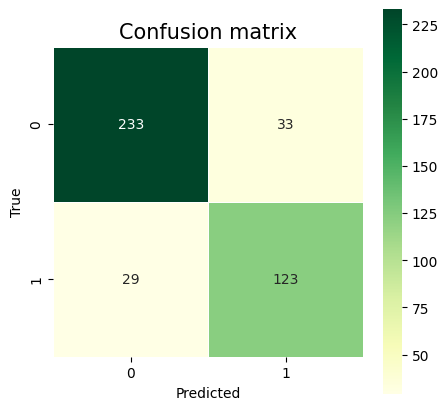

In [68]:
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGn', square=True, linewidth=.5)
plt.title('Confusion matrix', fontsize=15)
plt.ylabel('True', fontsize=10)
plt.xlabel('Predicted', fontsize=10)
plt.show()

In [69]:
pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), 
                   precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)], 
    index=['accuracy', 'recall', 'precision', 'roc-auc'],
    columns=['Test']).T

,accuracy,recall,precision,roc-auc
Test,0.851675,0.809211,0.788462,0.842575


## Permutation importances

In [70]:
perm_result = permutation_importance(random_search, X_test, y_test,\
                                     scoring='accuracy', n_repeats=30, random_state=42)

In [71]:
imp_df = pd.DataFrame({'features':X_test.columns.tolist(),
                       'mean':perm_result.importances_mean,
                       'std':perm_result.importances_std}).sort_values(by='mean', ascending=True)

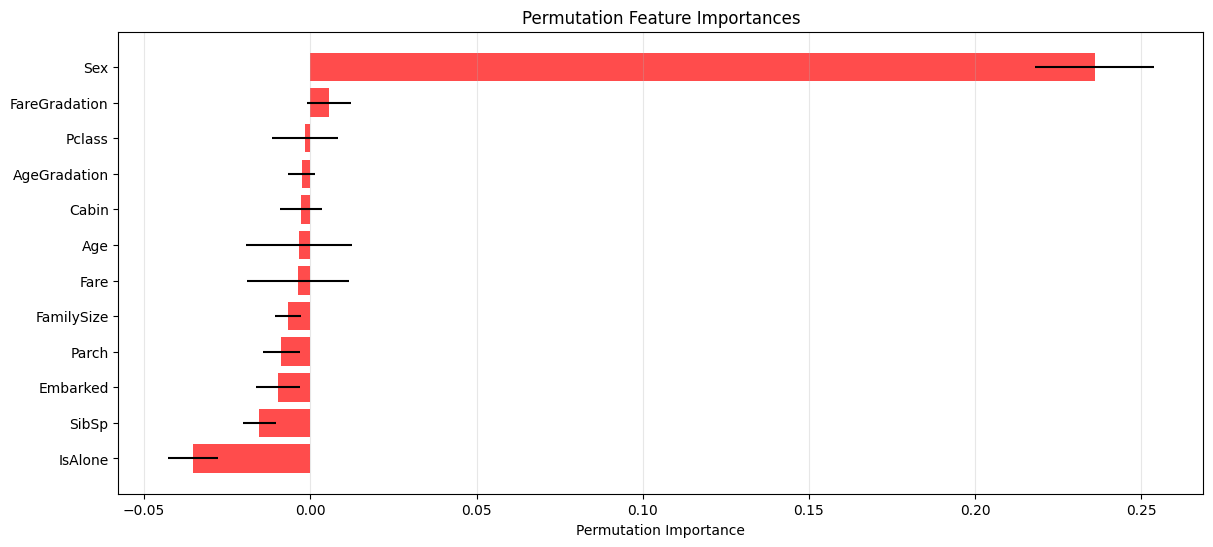

In [72]:
plt.figure(figsize=(14, 6))
plt.barh(imp_df['features'], imp_df['mean'], 
         xerr=imp_df['std'], alpha=0.7, color='red')
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances')
plt.grid(axis='x', alpha=0.3)
plt.show()

In [73]:
res = pd.DataFrame({'PassengerId':test['PassengerId'],
                    'Survived':y_pred})

In [74]:
res

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [75]:
#res.to_csv('res.csv', index=False)